<a href="https://maestriasydiplomados.tec.mx/posgrados/maestria-en-inteligencia-artificial-aplicada"><img src="logo_MR4010.png"></a>
<h1> <div align="center"> Dr. David Antonio-Torres</div> </h1>

# DETECCION DE PEATONES CON HOG Y SVM
### www.gti.ssr.upm.es/data/Vehicle_database.html

# Se cargan las bibliotecas necesarias

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
from skimage.feature import hog

# Se importan los dos datasets

### https://docs.python.org/3/library/glob.html  Cambiar link

In [3]:
import glob
pedestrian = glob.glob("dataset/pedestrian/*.jpg")
no_pedestrian = glob.glob("dataset/no-pedestrian/*.jpg")

In [4]:
len(pedestrian)


808

In [5]:
len(no_pedestrian)

808

# Se muestra una imagen con peatón

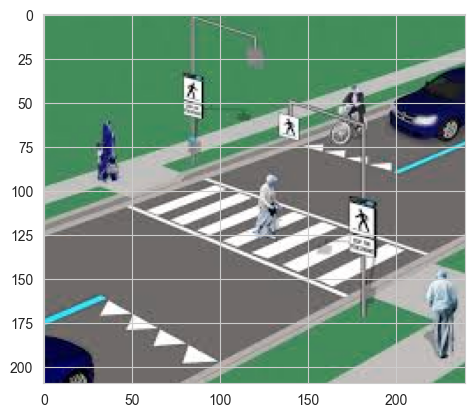

In [6]:
img_color = cv2.imread(pedestrian[10])
plt.imshow(img_color)


# Para fines de demostración se calcula el HOG de la imagen

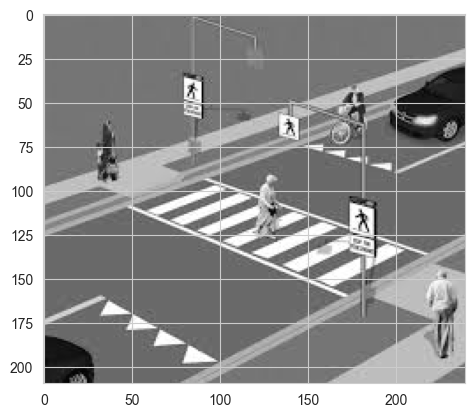

In [7]:
img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray,cmap="gray")

In [8]:
features,hog_img = hog(img_gray,
                       orientations = 11,
                       pixels_per_cell = (16,16),
                       cells_per_block = (2,2),
                       transform_sqrt = False,
                       visualize = True,
                       feature_vector = True)

In [9]:
features.shape

(7392,)

In [10]:
hog_img.shape

(210, 240)

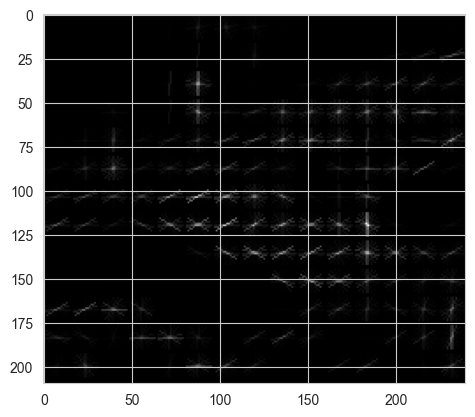

In [11]:
plt.imshow(hog_img,cmap = 'gray')

# Se extraen las features del HOG para ambos tipos de datos

In [12]:
pedestrian_hog_accum = []

for i in pedestrian:
    img_color = mpimg.imread(i)
    img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    
    pedestrian_hog_feature, pedestrian_hog_img = hog(img_gray,
                                               orientations = 11,
                                               pixels_per_cell = (16,16),
                                               cells_per_block = (2,2),
                                               transform_sqrt = False,
                                               visualize = True,
                                               feature_vector = True)
    
    pedestrian_hog_accum.append(pedestrian_hog_feature)

In [13]:
# Ajustar dimensiones de los arrays en pedestrian_hog_accum
min_shape = min(arr.shape[0] for arr in pedestrian_hog_accum)
pedestrian_hog_accum_adjusted = [arr[:min_shape] for arr in pedestrian_hog_accum]

# Realizar la concatenación vertical
X_pedestrian = np.vstack(pedestrian_hog_accum_adjusted).astype(np.float64)
y_pedestrian = np.ones(len(X_pedestrian))

In [14]:
X_pedestrian.shape

(808, 3388)

In [15]:
y_pedestrian.shape

(808,)

In [16]:
nopedestrian_hog_accum = []

for i in no_pedestrian:
    img_color = mpimg.imread(i)
    img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    
    nopedestrian_hog_feature, nopedestrian_hog_img = hog(img_gray,
                                               orientations = 11,
                                               pixels_per_cell = (16,16),
                                               cells_per_block = (2,2),
                                               transform_sqrt = False,
                                               visualize = True,
                                               feature_vector = True)
    
    nopedestrian_hog_accum.append(nopedestrian_hog_feature)

In [17]:
# Ajustar dimensiones de los arrays en pedestrian_hog_accum
min_shape_noped = min(arr.shape[0] for arr in nopedestrian_hog_accum)
nopedestrian_hog_accum_adjusted = [arr[:min_shape_noped] for arr in nopedestrian_hog_accum]

print(min_shape)

X_nopedestrian = np.vstack(nopedestrian_hog_accum_adjusted).astype(np.float64)
y_nopedestrian = np.zeros(len(X_nopedestrian))

3388


In [18]:
X_nopedestrian.shape

(808, 2112)

In [19]:
y_nopedestrian.shape

(808,)

# Se combinan ambos tipos de datos para alimentar el SVM

In [20]:
#X = np.vstack((X_pedestrian,X_nopedestrian))
#X.shape

# Ajustar dimensiones de los arrays X_pedestrian y X_nopedestrian
min_shape = min(X_pedestrian.shape[1], X_nopedestrian.shape[1])
X_pedestrian_resized = np.resize(X_pedestrian, (X_pedestrian.shape[0], min_shape))
X_nopedestrian_resized = np.resize(X_nopedestrian, (X_nopedestrian.shape[0], min_shape))

# Realizar la concatenación vertical
X = np.vstack((X_pedestrian_resized, X_nopedestrian_resized))
X.shape

(1616, 2112)

In [21]:
y = np.hstack((y_pedestrian,y_nopedestrian))
y.shape

(1616,)

# Se generan los datos de entrenamiento y de prueba

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [23]:
X_train.shape

(1131, 2112)

In [24]:
X_test.shape

(485, 2112)

# Se importa el Clasificador y se entrena

In [25]:
#from sklearn.svm import LinearSVC

#svc_model = LinearSVC()
#svc_model.fit(X_train, y_train)
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_train,y_train)

SVC()

In [26]:
y_predict = svc_model.predict(X_test)

<AxesSubplot: >

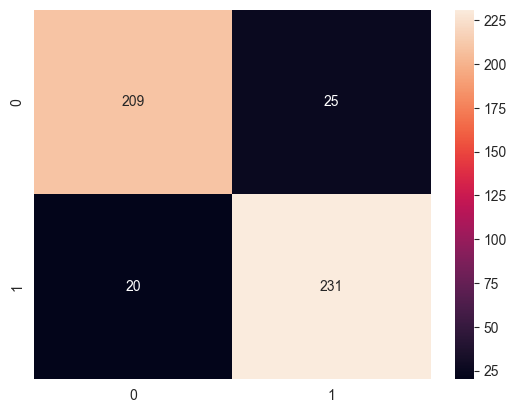

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test,y_predict)
sns.heatmap(cm, annot=True, fmt = "d")

In [28]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90       234
         1.0       0.90      0.92      0.91       251

    accuracy                           0.91       485
   macro avg       0.91      0.91      0.91       485
weighted avg       0.91      0.91      0.91       485



# GridSearchCV

In [29]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [30]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=4)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.507 total time=   1.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.509 total time=   1.5s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.509 total time=   1.4s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.509 total time=   1.4s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.504 total time=   1.5s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.714 total time=   1.4s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.677 total time=   1.5s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.735 total time=   1.5s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.668 total time=   1.5s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.695 total time=   1.7s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.714 total time=   1.5s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=4)

In [31]:
grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [32]:
grid.best_estimator_

SVC(C=10, gamma=0.1)

In [33]:
grid_predictions = grid.predict(X_test)

<AxesSubplot: >

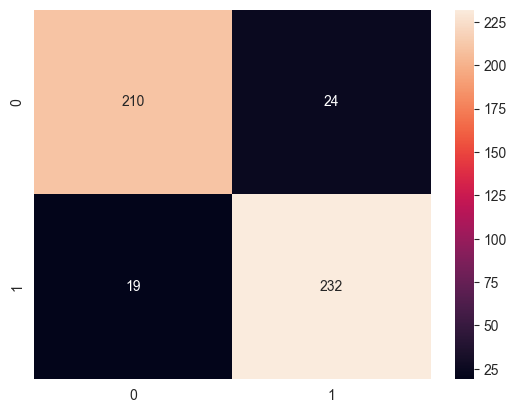

In [34]:
cm = confusion_matrix(y_test,grid_predictions)
sns.heatmap(cm, annot=True, fmt = "d")

In [35]:
print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91       234
         1.0       0.91      0.92      0.92       251

    accuracy                           0.91       485
   macro avg       0.91      0.91      0.91       485
weighted avg       0.91      0.91      0.91       485



In [36]:
from joblib import dump

# Obtener el mejor modelo de GridSearchCV
best_model = grid.best_estimator_

# Guardar el mejor modelo en un archivo
dump(best_model, 'modelo_svm.xml')

['modelo_svm.xml']